In [39]:
#!pip install -U tensorflow_datasets

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds

In [4]:
tfds.disable_progress_bar()

In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [7]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to C:\Users\everl\tensorflow_datasets\fashion_mnist\3.0.1.incompleteJMLZBW\fashion_mnist-train.tfrecord
Shuffling and writing examples to C:\Users\everl\tensorflow_datasets\fashion_mnist\3.0.1.incompleteJMLZBW\fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to C:\Users\everl\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [10]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [9]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [19]:
train_dataset

<PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

### Preprocess the data
The value of each pixel in the image data is an integer in the range [0,255]. For the model to work properly, these values need to be normalized to the range [0,1]. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [20]:
def normalizar(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalizar)
test_dataset = test_dataset.map(normalizar)

train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

In [37]:
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))

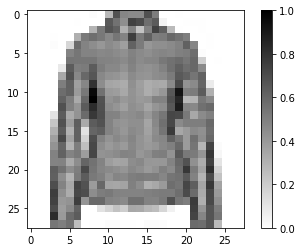

In [38]:
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

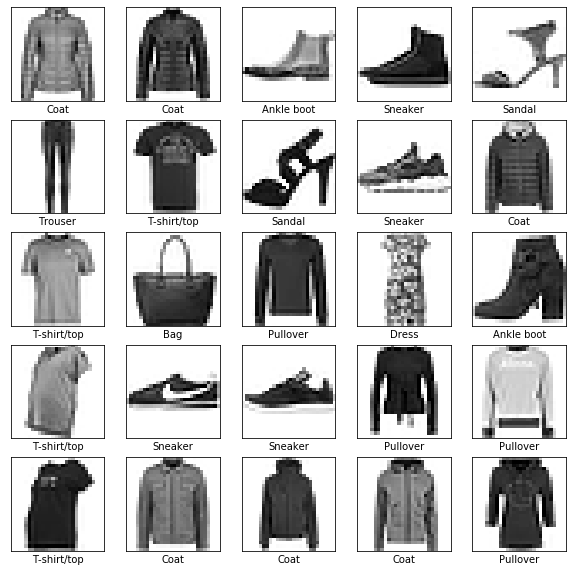

In [40]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

### Model TensorFlow

In [42]:
l0 = tf.keras.layers.Flatten(input_shape=(28,28,1))
l1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
l2 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

Flattening: The process of converting a 2d image into 1d vector   
ReLU: An activation function that allows a model to solve nonlinear problems   
Softmax: A function that provides probabilities for each possible output class

This network has three layers:

* **input** `tf.keras.layers.Flatten` — This layer transforms the images from a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels (28\*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

* **"hidden"** `tf.keras.layers.Dense`— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **output**  `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

> Note: Using `softmax` activation and `SparseCategoricalCrossentropy()` has issues and which are patched by the `tf.keras` model. A safer approach, in general, is to use a linear output (no activation function) with `SparseCategoricalCrossentropy(from_logits=True)`.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [43]:
model = tf.keras.Sequential([l0,l1,l2])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [46]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4995 - accuracy: 0.8245
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3773 - accuracy: 0.8652
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3388 - accuracy: 0.8754
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3085 - accuracy: 0.8870
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2924 - accuracy: 0.8928


In [47]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3365 - accuracy: 0.8788
Accuracy on test dataset: 0.8788


In [52]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

In [53]:
predictions.shape

(32, 10)

In [54]:
predictions[0]

array([7.79808374e-07, 5.65026039e-06, 1.49945570e-02, 1.12021155e-06,
       9.59163487e-01, 7.43249975e-11, 2.58324537e-02, 1.06498955e-10,
       1.91183676e-06, 6.04437819e-11], dtype=float32)

In [55]:
np.argmax(predictions[0])

4

In [56]:
test_labels[0]

4

In [57]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

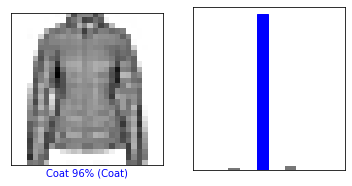

In [58]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

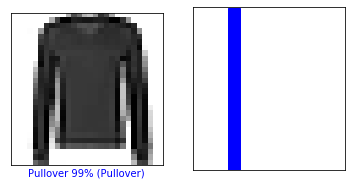

In [59]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

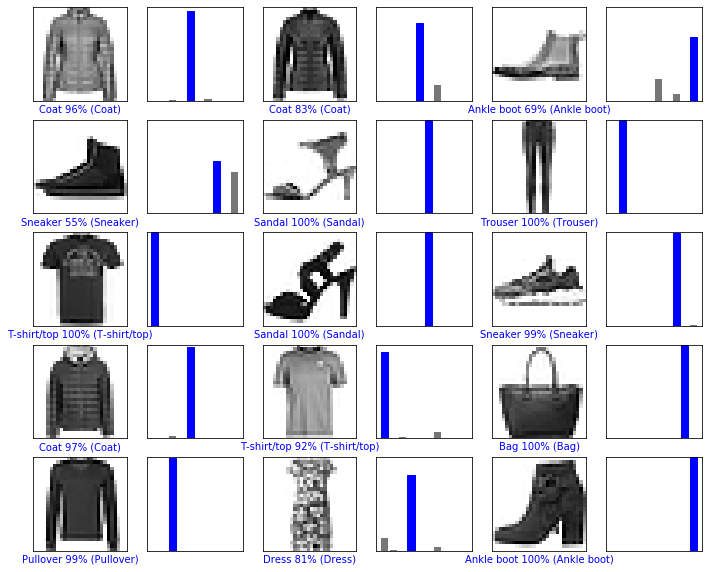

In [60]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [62]:
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [63]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [64]:
predictions_single = model.predict(img)

print(predictions_single)

[[7.7980900e-07 5.6502649e-06 1.4994562e-02 1.1202114e-06 9.5916337e-01
  7.4324991e-11 2.5832500e-02 1.0649935e-10 1.9118381e-06 6.0443775e-11]]


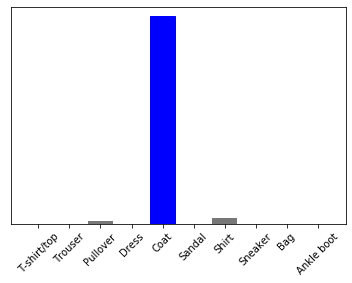

In [65]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [66]:
np.argmax(predictions_single[0])

4